In [ ]:
# default_exp imgaug
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#export
from pathlib import Path
import pickle
from io import BytesIO
import uuid

import cv2
import requests
import numpy as np
from matplotlib.pyplot import imread
from tqdm import tqdm


# Augmenting Images

> A collection of functions used to augment the pokemon card images.


## Borrowed code


I used these scripts of image manipulation https://github.com/vxy10/ImageAugmentation. They are included here pretty much as is, but I adjusted the brightness function to produce what I thought were more realistic variations for this use case.

A function to adjust the brightness of the image

In [ ]:
# export
def augment_brightness(image,brightness):
    """Returns an image with randomly adjusted brightness"""
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    # I modified this to suit my needs
    random_bright = brightness+np.random.uniform(low=1-brightness, high=1+brightness)
    image1[:,:,2] = (image1[:,:,2]*random_bright).clip(0,254)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)    
    return image1


The main transformations. 

In [ ]:
# export
def transform_image(img,ang_range=0,shear_range=0,trans_range=0, scale_range=1e-4,brightness=0):
    """
    This function transforms images to generate new images.
    
    From https://github.com/vxy10/ImageAugmentation.
    Image
    ang_range -- Range of angles for rotation
    shear_range -- Range of values to apply affine transform to
    trans_range -- Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation
    """
    
    # zoom / crop
    height, width, channels = img.shape

    scale=np.random.uniform(low=1-scale_range, high=1+scale_range)
    centerX,centerY=int(height/2),int(width/2)
    radiusX,radiusY= int(np.round(scale*height/2)),int(np.round(scale*width/2))
    minX,maxX=centerX-radiusX,centerX+radiusX
    minY,maxY=centerY-radiusY,centerY+radiusY

    if scale > 1:
        # zoom out
        new_image = np.zeros(((maxX-minX)+1, (maxY-minY)+1,3),dtype=np.uint8)
        x0=-1*minX; y0=-1*minY
        new_image[y0:y0+height,x0:x0+width,:]=img
        img=new_image.copy()
        
    else:
        cropped = img[minX:maxX, minY:maxY]
        resized_cropped = cv2.resize(cropped, (width, height)) 
        img=resized_cropped
    
    
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    
    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)

    
    # Apply the transforms
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    
    # Brightness
    if brightness != 0:
        img = augment_brightness(img,brightness)
    
    # ensure it is same as original size
    img = cv2.resize(img, (width, height), interpolation = cv2.INTER_AREA) 
    
    return img

Let's pick a card where we only have one version and augment it to synthetically create something that looks like a set of images of a card that might be captured on a phone.

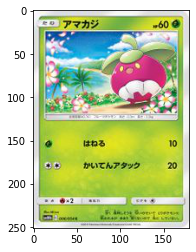

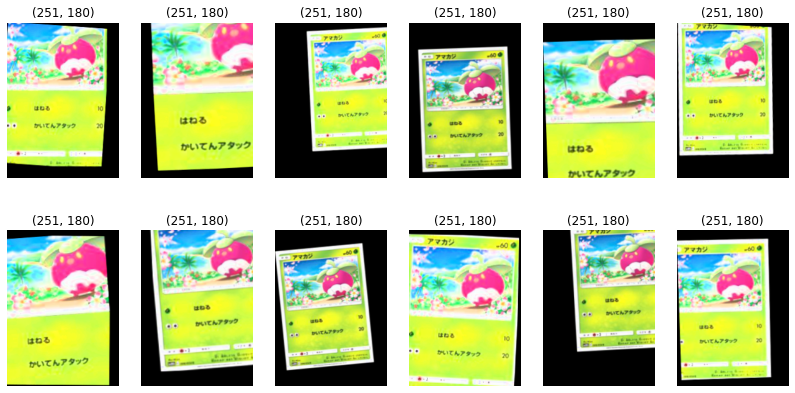

In [ ]:
# export 
BKG_SRC = 'https://pokedexproject.s3.eu-west-2.amazonaws.com/background_images/'

def fetch_background_images(src=BKG_SRC, n_images=15):
    
    background_images=[]
    
    for i in range(1, n_images+1):
        r=requests.get(src+f'back{i}.jpg')
        d=imread(BytesIO(r.content),0)
        background_images.append(d)

    return background_images

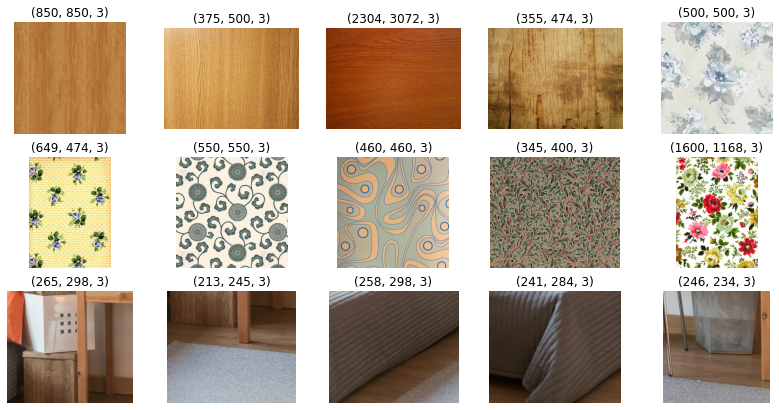

In [ ]:
# export 
def apply_random_background(img,background_images):
    """
    simple image compositor
    select random background image from the set provided
    img : target image (numpy array)
    background_images: list of images (numpy array) as backgrounds
    """
    img1 = img.copy()
    N = len(background_images)
    i = int(np.clip(np.round((N-1)*np.random.uniform()),0,N-1))
    img2=cv2.resize(background_images[i],img.shape[::-1][1:])
    
    # create mask for empty areas of target image
    idx=(img<5)
    
    # copy background into those empty areas
    img1[idx]=img2[idx]
    
    return img1


And this is how it would be applied to an image.

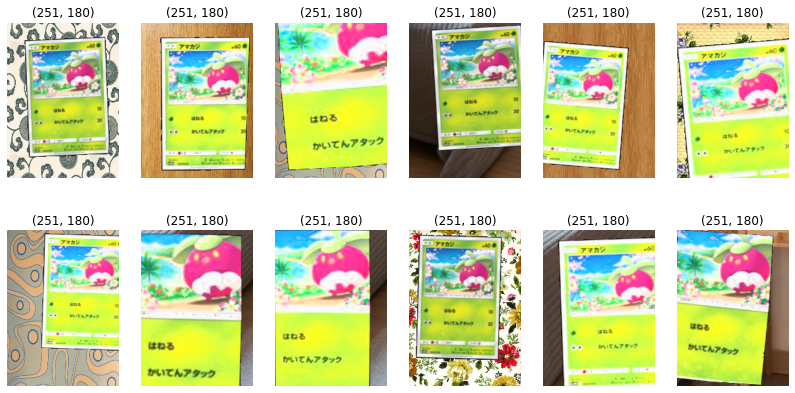

These are the stages of development:
    - created a small real world validation set, labelled by hand.
    - test vanilla performance (no augmentation) against that RW validation set.
    - do synthetic augmentation
    - test against RW validation set
    - learn with sythetic validation set then test performance against RW set - can I use synthetic data to generalise this problem so that I don't have to provde manually labelled sets.
    
    

In [ ]:
# export
def img_s3keys(card):
    return [card.get('name')+'/'+i.split('/')[-1] for i in card.get('img_urls')]

In [ ]:
#export
def augment_card_and_save(card, n_images_out = 100, to=Path('.')):
    """Produce augmented copies of original image"""
    for key in img_s3keys(card):
        if key[-3:] == 'jpg':
            src_img = imgfetch.fetch_card_img_s3(key)
            for i in tqdm(range(n_images_out)):
                img = transform_image(src_img, ang_range=7.5, shear_range=2, trans_range=20, scale_range=0.25, brightness=0.3)
                img = apply_random_background(img, background_images)                      

                # convert jpg and store
                bimg=Image.fromarray(img)           
                imgByteArr = io.BytesIO()
                bimg.save(imgByteArr, format='jpeg')
                fname = f"{uuid.uuid4().hex}.jpg"
                imgfetch.save_image(imgByteArr.getvalue(), to/fname)


TypeError: unhashable type: 'list'

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 01_scraper.ipynb.
Converted 02_augmentation.ipynb.
Converted 03_interpretation.ipynb.
Converted ExampleBlog.ipynb.
Converted Training.ipynb.
Converted index.ipynb.
